<h2> Data analysis </h2>

similoar problem: https://towardsdatascience.com/time-series-analysis-and-forecasting-of-web-service-metrics-1e15d7fb72c2

imports

In [612]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import datetime

path to csv raw data

In [613]:
DATA_PATH = '../../../data/raw_data/resultsOfFCRapp2cores8gb.csv'

In [614]:
TIME_COLUMN = 'time'
RELEVANT_COLUMNS = ['AvgResponseTime', 'nrOfInstances', 'numebrOfRequest']

In [615]:
data = pd.read_csv(DATA_PATH)

data.tail(5)

time  AvgResponseTime  nrOfInstances  AvgMemory  \
3090  2020-06-30 14:00:36.998              NaN            NaN        NaN   
3091  2020-06-30 14:00:37.462              0.0            2.0        NaN   
3092  2020-06-30 14:00:41.298              NaN            NaN  41.461579   
3093  2020-06-30 14:00:41.998              NaN            NaN        NaN   
3094  2020-06-30 14:00:42.398              0.0            2.0        NaN   

        AvgCPU  numebrOfRequest  Latency  
3090  6.609433              NaN      NaN  
3091       NaN              NaN      NaN  
3092       NaN              NaN      NaN  
3093  6.553273              NaN      NaN  
3094       NaN              NaN      NaN

In [616]:
data.isna().sum()

time                  0
AvgResponseTime    1911
nrOfInstances      1911
AvgMemory          2974
AvgCPU             1912
numebrOfRequest    2469
Latency            2469
dtype: int64

relevant columns selection

In [617]:
data = data[RELEVANT_COLUMNS + [TIME_COLUMN]]
print(f'original data shape is {data.shape}')

original data shape is (3095, 4)


removing rows with Nans only

In [618]:
data = data.dropna(subset=RELEVANT_COLUMNS, axis=0, how='all')
data = data.reset_index(drop=True)
print(f'data shape after removing rows with all nans is {data.shape}')

data shape after removing rows with all nans is (1810, 4)


In [619]:
timedelta = pd.to_datetime(data[TIME_COLUMN][data.shape[0] - 1]) - pd.to_datetime(data[TIME_COLUMN][0])
print(f'Time delta is {timedelta.components[0]} days, {timedelta.components[1]} hours, {timedelta.components[2]} minutes')

Time delta is 0 days, 1 hours, 59 minutes


converting dates to integers (in order to handle irregular sampled data) 

In [620]:
start_date = pd.to_datetime(data.time[0]).value
end_date = pd.to_datetime(data.time[data.shape[0] - 1]).value
data[TIME_COLUMN + 'org'] = data[TIME_COLUMN]
data[TIME_COLUMN] = pd.Series([pd.to_datetime(x).value - start_date for x in data[TIME_COLUMN].values])
# data[TIME_COLUMN] = (data[TIME_COLUMN] - data[TIME_COLUMN].mean()) / data[TIME_COLUMN].std()

In [621]:
data.head(3)

AvgResponseTime  nrOfInstances  numebrOfRequest         time  \
0              NaN            NaN              1.0            0   
1              NaN            NaN              1.0  38600000000   
2              NaN            NaN              1.0  39660000000   

                   timeorg  
0  2020-06-30 12:01:33.487  
1  2020-06-30 12:02:12.087  
2  2020-06-30 12:02:13.147

Frequency

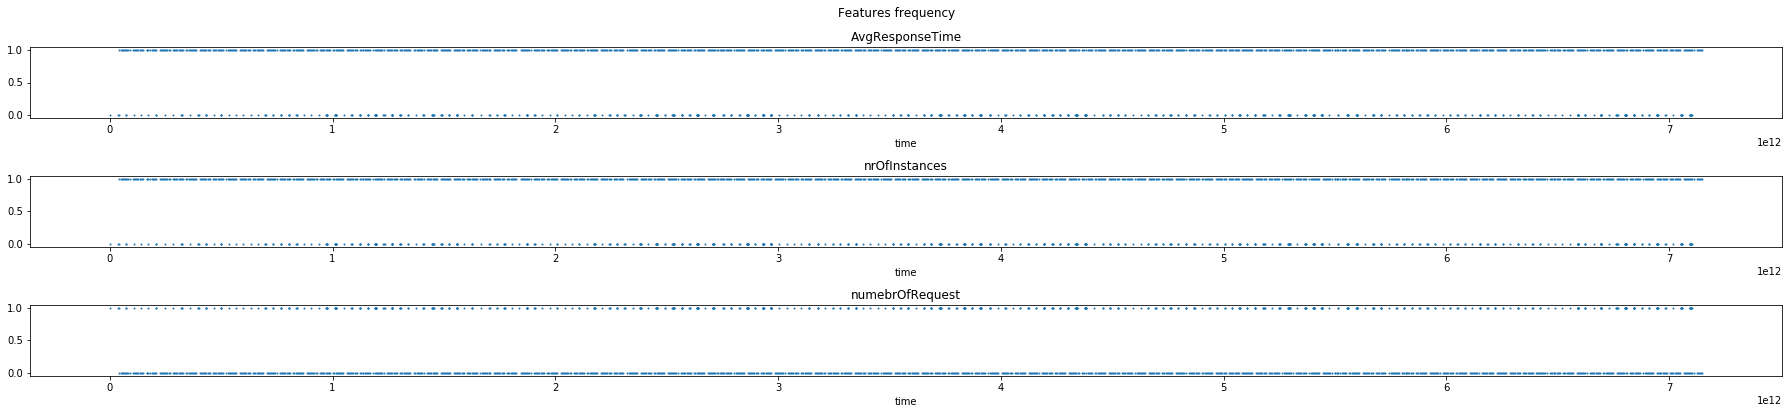

In [622]:
fig, axs = plt.subplots(3,1, figsize=(25,6))
fig.suptitle('Features frequency')

for i, column in enumerate(RELEVANT_COLUMNS):
    axs[i].set_title(column)
    axs[i].set_xlabel('time')
    axs[i].plot(data[TIME_COLUMN].values ,pd.to_numeric(data[column]).notna().astype(int).values, 'o', markersize=1)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [623]:
series = data[[TIME_COLUMN, RELEVANT_COLUMNS[2]]].dropna()
diff = series.diff()
diff['time'].describe()

count    6.250000e+02
mean     1.135962e+10
std      1.548552e+10
min      0.000000e+00
25%      4.670000e+08
50%      1.005000e+09
75%      3.299100e+10
max      4.237400e+10
Name: time, dtype: float64

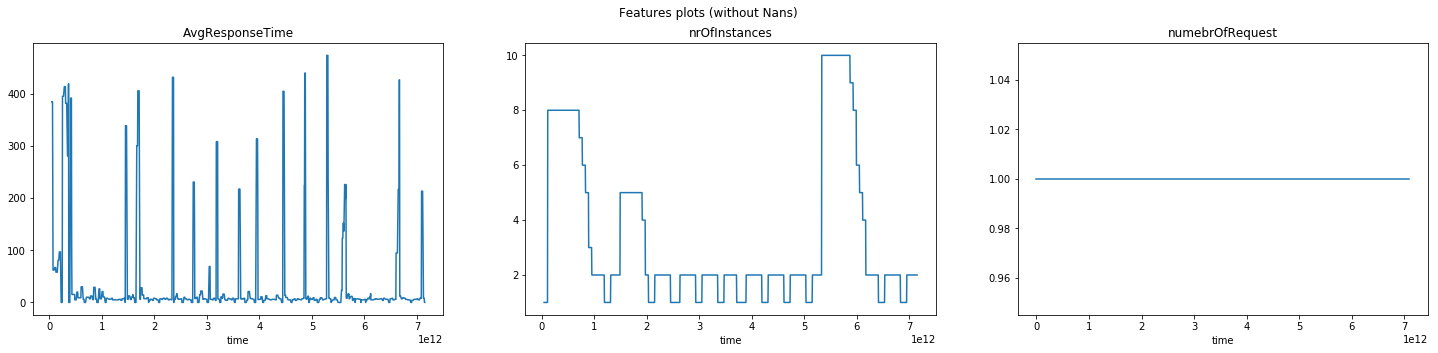

In [624]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
fig.suptitle('Features plots (without Nans)')

for i, column in enumerate(RELEVANT_COLUMNS):
    axs[i].set_title(column)
    axs[i].set_xlabel('time')
    tmp_data = data[[TIME_COLUMN, column]].dropna()
    axs[i].plot(tmp_data[TIME_COLUMN].values ,pd.to_numeric(tmp_data[column]).values)

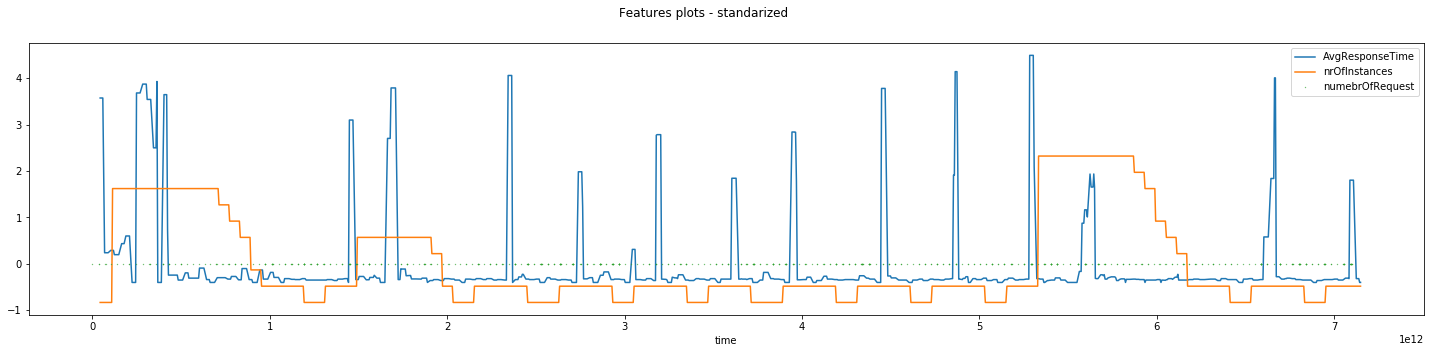

In [625]:
fig, axs = plt.subplots(figsize=(25,5))
fig.suptitle('Features plots - standarized')
axs.set_xlabel('time')

for i, column in enumerate(RELEVANT_COLUMNS[:2]):
    tmp_data = data[[TIME_COLUMN, column]].dropna()
    y = pd.to_numeric(tmp_data[column]).values
    axs.plot(tmp_data[TIME_COLUMN].values ,(y - y.mean()) / y.std(), label=column)

tmp_data = data[[TIME_COLUMN, RELEVANT_COLUMNS[-1]]].dropna()
y = pd.to_numeric(tmp_data[RELEVANT_COLUMNS[-1]]).values  -1 
axs.plot(tmp_data[TIME_COLUMN].values ,y, 'o', markersize=0.3, label=RELEVANT_COLUMNS[-1])

plt.legend()

dealing with irregulary sampled time series data <br>
method 1

Number of requests agregation (sum) over not empty average respone time time points 

In [626]:
df = data

nonzero = (df[RELEVANT_COLUMNS[0]].notna()) 

df['notnan'] = nonzero.cumsum()
tmp = df.groupby(['notnan']).sum()[RELEVANT_COLUMNS[-1]]

df = df.dropna(subset=[RELEVANT_COLUMNS[0]])
df = df.reset_index(drop=True)

df[RELEVANT_COLUMNS[-1]] = tmp.values[:-1]

agregated number of requests statistics

In [627]:
df[RELEVANT_COLUMNS[-1]].describe()

count    1184.000000
mean        0.528716
std         1.288818
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: numebrOfRequest, dtype: float64

data frame with agregated number od requests

In [628]:
print(f'new data shape is {df.shape}')
df.head()

new data shape is (1184, 6)


AvgResponseTime  nrOfInstances  numebrOfRequest         time  \
0            385.0            1.0              3.0  43911000000   
1            385.0            1.0              0.0  48914000000   
2            385.0            1.0              0.0  53999000000   
3            385.0            1.0              0.0  58917000000   
4            223.5            1.0              0.0  63938000000   

                   timeorg  notnan  
0  2020-06-30 12:02:17.398       1  
1  2020-06-30 12:02:22.401       2  
2  2020-06-30 12:02:27.486       3  
3  2020-06-30 12:02:32.404       4  
4  2020-06-30 12:02:37.425       5

plots

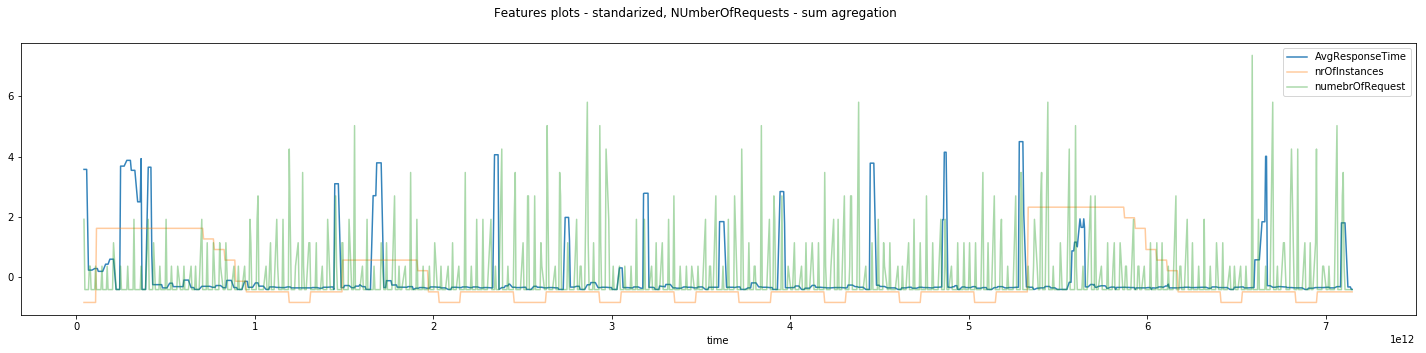

In [629]:
fig, axs = plt.subplots(figsize=(25,5))
fig.suptitle('Features plots - standarized, NUmberOfRequests - sum agregation')
axs.set_xlabel('time')

for i, column in enumerate(RELEVANT_COLUMNS):
    tmp_data = df[[TIME_COLUMN, column]].dropna()
    y = pd.to_numeric(tmp_data[column]).values
    if i == 0:
        axs.plot(tmp_data[TIME_COLUMN].values ,(y - y.mean()) / y.std(), alpha=0.9, label=column)
    else:
        axs.plot(tmp_data[TIME_COLUMN].values ,(y - y.mean()) / y.std(), alpha=0.4, label=column)
        
plt.legend()

method 2

Nans where requests occurs  are replaced by a value between the nearest registered data (weighted mean)

In [630]:
df = data

df['AvgResponseTime'] = [385] + list(df['AvgResponseTime'].values[1:])
df['nrOfInstances'] = [1] + list(df['nrOfInstances'].values[1:])

df.tail(3)

AvgResponseTime  nrOfInstances  numebrOfRequest           time  \
1807              8.0            2.0              NaN  7138949000000   
1808              0.0            2.0              NaN  7143975000000   
1809              0.0            2.0              NaN  7148911000000   

                      timeorg  notnan  
1807  2020-06-30 14:00:32.436    1182  
1808  2020-06-30 14:00:37.462    1183  
1809  2020-06-30 14:00:42.398    1184

In [631]:
target_ind = df.dropna(subset=['nrOfInstances']).index
target_ind

Int64Index([   0,    3,    4,    5,    6,    7,    8,   10,   12,   13,
            ...
            1794, 1800, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809],
           dtype='int64', length=1185)

In [632]:
new_column_1, new_column_2 = [], []
for i, j in zip(target_ind, target_ind[1:]):
    new_column_1.append(df.iloc[i]['AvgResponseTime'])
    new_column_2.append(df.iloc[i]['nrOfInstances'])
    k = i
    while j - k > 1:
        p = (df.iloc[j]['time'] - df.iloc[j]['time']) / (df.iloc[j]['time'] - df.iloc[i]['time'])
        new_column_1.append(p * df.iloc[i]['AvgResponseTime'] + (1 - p) * df.iloc[j]['AvgResponseTime'])
        new_column_2.append(p * df.iloc[i]['nrOfInstances'] + (1 - p) * df.iloc[j]['nrOfInstances'])
        k += 1

In [633]:
df['AvgResponseTime'], df['nrOfInstances'] = new_column_1 + [df['AvgResponseTime'].values[-1]], new_column_2 + [df['nrOfInstances'].values[-1]]

df['numebrOfRequest'] = pd.to_numeric(df['numebrOfRequest']).fillna(0)

In [634]:
print(f'new data shape is {df.shape}')
df.head(3)

new data shape is (1810, 6)


AvgResponseTime  nrOfInstances  numebrOfRequest         time  \
0            385.0            1.0              1.0            0   
1            385.0            1.0              1.0  38600000000   
2            385.0            1.0              1.0  39660000000   

                   timeorg  notnan  
0  2020-06-30 12:01:33.487       0  
1  2020-06-30 12:02:12.087       0  
2  2020-06-30 12:02:13.147       0

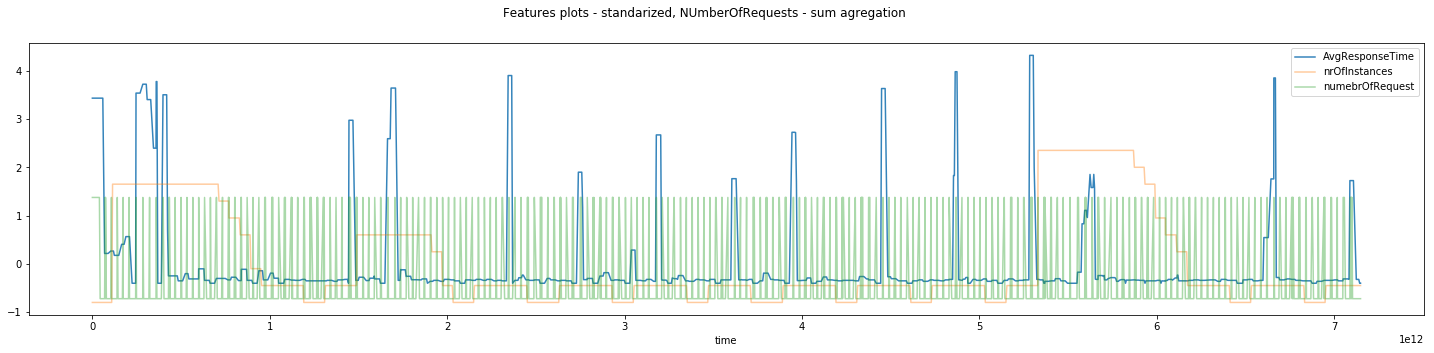

In [635]:
fig, axs = plt.subplots(figsize=(25,5))
fig.suptitle('Features plots - standarized, NUmberOfRequests - sum agregation')
axs.set_xlabel('time')

for i, column in enumerate(RELEVANT_COLUMNS):
    tmp_data = df[[TIME_COLUMN, column]].dropna()
    y = pd.to_numeric(tmp_data[column]).values
    if i == 0:
        axs.plot(tmp_data[TIME_COLUMN].values ,(y - y.mean()) / y.std(), alpha=0.9, label=column)
    else:
        axs.plot(tmp_data[TIME_COLUMN].values ,(y - y.mean()) / y.std(), alpha=0.4, label=column)
        
        
plt.legend()

running simple model - facebook prophet, poor results

In [636]:
# from scipy.signal import savgol_filter

base = datetime.datetime.today()
fake_date_list = [base - datetime.timedelta(days=x) for x in range(df.shape[0])]

prophet_df = pd.DataFrame()
#prophet_df['ds'], prophet_df['y'] = fake_date_list, savgol_filter(df['AvgResponseTime'].values, 21, 2)
prophet_df['ds'], prophet_df['y'] = fake_date_list, df['AvgResponseTime'].values

prophet_df_tr = prophet_df.head(int(prophet_df.shape[0] * 0.9))
prophet_df.head(3)

ds      y
0 2020-10-23 10:45:19.260570  385.0
1 2020-10-22 10:45:19.260570  385.0
2 2020-10-21 10:45:19.260570  385.0

In [637]:
m = Prophet()
m.fit(prophet_df_tr)

future = m.make_future_dataframe(periods=prophet_df.shape[0] - int(prophet_df.shape[0] * 0.9))
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
1805 2021-04-18 10:45:19.260570
1806 2021-04-19 10:45:19.260570
1807 2021-04-20 10:45:19.260570
1808 2021-04-21 10:45:19.260570
1809 2021-04-22 10:45:19.260570

In [638]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
1805 2021-04-18 10:45:19.260570  137.719060   15.552292  251.855161
1806 2021-04-19 10:45:19.260570  137.437630   15.726354  266.921213
1807 2021-04-20 10:45:19.260570  138.608653   13.384052  258.547643
1808 2021-04-21 10:45:19.260570  140.303067   21.289572  253.598936
1809 2021-04-22 10:45:19.260570  139.249094   25.512514  251.959092

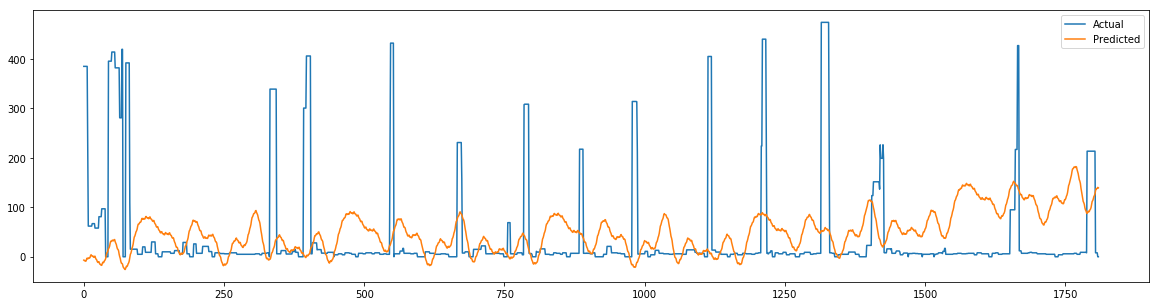

In [639]:
y_true = prophet_df['y'].values
y_pred = forecast['yhat'].values

plt.figure(figsize=(20,5))
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()